### This file is used to learnig the solution operator for the boundary integral equations (from g to h) for PDEs:
$$ \begin{cases}
u - \tau \Delta u = 0, & x \in \Omega, \\
u = g, & x \in \partial \Omega,
\end{cases} $$
where $\Omega$ is a petal-shaped domain and parameter $\tau \in [0.05, 0.1]$.

Note that it is equivalent to solve $\frac{1}{\tau} u - \Delta u = 0$.

#### Given a fixed $g$, the solution of this PDE can be written as
$$ u(x) = \int_{\partial \Omega} \frac{\partial G_0(x,y)}{\partial n_y} h(y) d s_y,\quad x \in \Omega, $$
where the density function $h$ is the solution of this boundary integral equation:
$$ \int_{\partial \Omega} \frac{\partial G_0(x_0,y)}{\partial n_y} h(y) d s_y + \frac{1}{2} h(x_0) = g(x_0),\quad x_0 \in \partial \Omega, $$
with the fundamental solution (of $\frac{1}{\tau} id - \Delta$):
$$G_0(x, y) = -\frac{1}{2 \pi} \mathbb{K}_0(\frac{|x - y|}{\sqrt{\tau}}), $$
here $\mathbb{K}_{\gamma}(x)$ is the modified Bessel function of the second kind of order $\gamma$.

Remark that $$\mathbb{K}_{0}(x) \approx - \ln(\frac{x}{2}) - \gamma_E + (1 - \gamma_E)\frac{x^2}{4}$$ and $$\mathbb{K}'_{0}(x) \approx - \frac{1}{x} + (1-\gamma_E)\frac{x}{2}$$ near $x = 0.$

Suppose that the domain boundary $\partial \Omega$ has a parametric representation: $\textbf{x} = x(t) = (x_1(t), x_2(t))\ \text{for}\ t \in [0, 4)$. The boundary integral equation above now reads:
$$
\frac{1}{2} h(t)+\frac{1}{2 \pi} \int_0^{4} \frac{\partial (-\mathbb{K}_0(\frac{|\textbf{x}(t) - \textbf{x}(s)|)}{\sqrt{\tau}})}{\partial \mathbf{n}_s} h(s)\left|\mathbf{x}^{\prime}(s)\right| d s=g(t) \quad \text { for } t \in[0, 4)
$$
or
$$
\frac{1}{2} h(t)+\frac{1}{2 \pi} \int_0^{4} k(t, s) h(s) d s=g(t) \quad \text { for } t \in[0, 4)
$$
with kernel
$$
k(t, s)=\left\{\begin{array}{ll}
- \mathbb{K}'_0(\frac{|\textbf{x}(t) - \textbf{x}(s)|}{\sqrt{\tau}}) \frac{x'_2(s) (x_1(s) - x_1(t)) - x'_1(s) (x_2(s) - x_2(t))}{\sqrt{\tau [(x_1(t
) - x_1(s))^2 + (x_2(t) - x_2(s))^2]}} & \text { if } s \neq t \\
\frac{1}{2} \frac{x''_2(t) x'_1(t) - x''_1(t) x'_2(t)}{x'_1(t)^2 + x'_2(t)^2} & \text { if } s=t
\end{array} .\right.
$$

#### Thus we can construct a network $\mathcal{NN}$ with parameters $\Theta$ from $g$ to $h$ which can be regarded as the solution of the corresponding boundary integral equation. We just need to sample functions $g$ from the proper space to get a dataset $\{g_i\}_{i=1}^{M}$, and the $\text{Loss}$ funciton can be setted as:
$$\text{Loss}(\Theta) = \frac{1}{M_{\text{train}}} \sum_{i = 1}^{M_{\text{train}}} \sum_{j = 1}^N \{[\int_{\partial \Omega} \frac{\partial G_0(x_j,y)}{\partial n_y} \mathcal{NN}(\Theta; y) d s_y + \frac{1}{2} \mathcal{NN}(\Theta; x_j)] - g_i(x_j)\}^2,$$
where $\{x_j\}_{j=1}^N$ are sample points on the boundary $\partial \Omega$.

In [1]:
import time
import os
import torch
import numpy as np
from torch import nn
from matplotlib import pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    gpu_info = torch.cuda.get_device_properties(0)
    print(f"GPU: {gpu_info.name}")
    print(f"GPU memory: {gpu_info.total_memory / 1024**2:.2f} MB")

GPU: NVIDIA GeForce RTX 4090
GPU memory: 24210.31 MB


In [19]:
class MLP(torch.nn.Module):
    def __init__(self, n_input, n_hidden, n_output, n_layers):
        super(MLP, self).__init__()
        self.act = nn.ReLU()
        self.layin = torch.nn.Linear(n_input, n_hidden)
        self.hidden_layers = torch.nn.ModuleList([torch.nn.Linear(n_hidden, n_hidden) for _ in range(n_layers)])
        self.layout = torch.nn.Linear(n_hidden, n_output)
    def forward(self, g):
       g = self.layin(g)
       g = self.act(g)
       for layer in self.hidden_layers:
           g = layer(g)
           g = self.act(g)
       h = self.layout(g)
       return h
    
class DeepONet(torch.nn.Module):
    def __init__(self, n_g, n_h, n_hidden, n_layers):
        super(DeepONet, self).__init__()
        self.for_tau = MLP(1, n_g, n_hidden, n_layers)
        # self.for_g_1 = torch.nn.Sequential(torch.nn.Linear(n_g, n_hidden), torch.nn.Linear(n_hidden, n_hidden), torch.nn.Linear(n_hidden, n_hidden))
        # self.for_g_2 = torch.nn.Sequential(torch.nn.Linear(n_hidden, n_h), torch.nn.Linear(n_h, n_h), torch.nn.Linear(n_h, n_h))
        self.for_g_1 = torch.nn.Linear(n_g, n_hidden)
        self.for_g_2 = torch.nn.Linear(n_hidden, n_h)
    def forward(self, tau, g):      #  tau: scalar, g: (batch_size, n_g)
       tau = tau + torch.zeros_like(g[:, 1].view(-1, 1))
       tau = self.for_tau(tau)
       g = self.for_g_1(g)
       h = self.for_g_2(tau * g)
       return h

In [4]:
def generate_flower_points(n, plot):
    theta = np.linspace(0, 2 * np.pi, 8 * n, endpoint=False)  # 均匀分布的角度
    r = 0.6 * (1 + 0.25 * np.sin(6 * theta))  # 计算极径
    x_boundary = r * np.cos(theta)
    y_boundary = r * np.sin(theta)
    boundary_points = np.column_stack((x_boundary, y_boundary))
    
    t_boundary = np.zeros((len(boundary_points), 1))
    for i in range(0, len(boundary_points)):
        t_boundary[i] = theta[i]
    
    x_vals = np.linspace(-1, 1, n + 1)
    y_vals = np.linspace(-1, 1, n + 1)
    xx, yy = np.meshgrid(x_vals, y_vals)
    interior_candidates = np.column_stack((xx.ravel(), yy.ravel()))
    
    r_candidate = np.sqrt(interior_candidates[:, 0]**2 + interior_candidates[:, 1]**2)
    theta_candidate = np.arctan2(interior_candidates[:, 1], interior_candidates[:, 0])
    r_max = 0.6 * (1 + 0.25 * np.sin(6 * theta_candidate))
    interior_points = interior_candidates[r_candidate <= 0.975 * r_max]
    
    if plot:
        plt.figure(figsize=(6, 6))
        plt.scatter(interior_points[:, 0], interior_points[:, 1], color='blue', label='Interior Points', s=10)
        plt.scatter(boundary_points[:, 0], boundary_points[:, 1], color='red', label='Boundary Points', s=1)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.title("Flower-Shaped Region Points")
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()
    
    return (2 * np.pi) / (8 * n), t_boundary, boundary_points, interior_points

In [5]:
taus = np.linspace(0.05, 0.1, 21)
N = 64
taus

array([0.05  , 0.0525, 0.055 , 0.0575, 0.06  , 0.0625, 0.065 , 0.0675,
       0.07  , 0.0725, 0.075 , 0.0775, 0.08  , 0.0825, 0.085 , 0.0875,
       0.09  , 0.0925, 0.095 , 0.0975, 0.1   ])

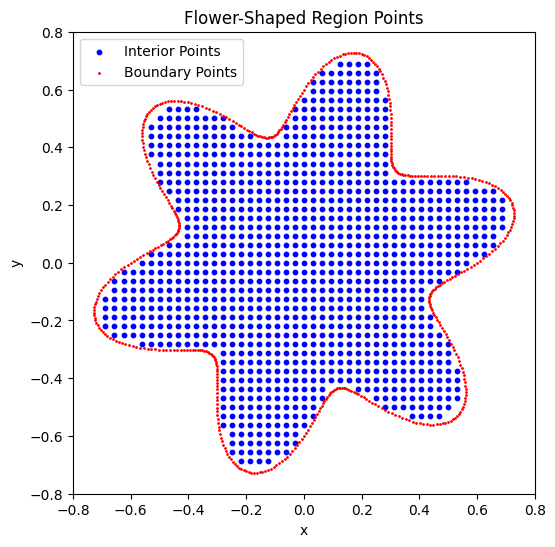

In [6]:
h, s_for_integral, x_bd, x_interior = generate_flower_points(N, True)
s_for_intergal_pt = torch.from_numpy(s_for_integral).clone().float().to(device).view(-1, 1)
x_bd_pt = torch.from_numpy(x_bd).clone().float().to(device)
x_interior_pt = torch.from_numpy(x_interior).clone().float().to(device)

In [7]:
def get_point3(theta):
    temp1 = 0.6 * (1 + 0.25 * np.sin(6 * theta))

    x = temp1 * np.cos(theta)
    y = temp1 * np.sin(theta)

    temp2 = 0.6 + 0.15 * np.sin(6 * theta)

    dx = -temp2 * np.sin(theta) + 0.9 * np.cos(theta) * np.cos(6 * theta)
    dy = temp2 * np.cos(theta) + 0.9 * np.sin(theta) * np.cos(6 * theta)

    temp3 = -5.55 * np.sin(6 * theta) - 0.6
    ddx = temp3 * np.cos(theta) - 1.8 * np.sin(theta) * np.cos(6 * theta)
    ddy = temp3 * np.sin(theta) + 1.8 * np.cos(theta) * np.cos(6 * theta)

    return x, y, dx, dy, ddx, ddy

In [8]:
from scipy.special import kv, kvp

def kernel_bd(tau, t, s):
    x1_s, x2_s, dx1_s, dx2_s, ddx1_s, ddx2_s = get_point3(s)
    x1_t, x2_t, dx1_t, dx2_t, ddx1_t, ddx2_t = get_point3(t)

    if (s != t):
        r = np.sqrt((x1_s - x1_t) ** 2 + (x2_s - x2_t) ** 2)
        result = - kvp(0, r / np.sqrt(tau), n=1) * (dx2_s * (x1_s - x1_t) - dx1_s * (x2_s - x2_t)) / (np.sqrt(tau) * r)
        return result
    else:
        return 0.5 * (ddx2_t * dx1_t - ddx1_t * dx2_t) / (dx1_t * dx1_t + dx2_t * dx2_t);
    
kernels_for_bd = torch.zeros(len(taus), len(x_bd), len(x_bd))
for k in range(len(taus)):
    for i in range(len(x_bd)):
        for j in range(len(x_bd)):
            kernels_for_bd[k, i, j] = h * kernel_bd(taus[k], s_for_integral[i, 0], s_for_integral[j, 0])

In [9]:
def predict_u_bd(net, tau, g):      # tau: scalar, g: (batch_size, n_g)
    flag = 0
    for i in range(len(taus)):
        if np.abs(tau - taus[i]) < 1e-6:
            kernel = kernels_for_bd[i, :, :]
            flag = 1
            # print(taus[i])
            
    if flag == 0 and tau > 0:
        kernel = torch.zeros(len(x_bd), len(x_bd))
        for i in range(len(x_bd)):
            for j in range(len(x_bd)):
                kernel[i, j] = h * kernel_bd(tau, s_for_integral[i, 0], s_for_integral[j, 0])
    else:
        exit("The value of tau is illegal!")

    kernel = kernel.to(device)
    result = 0.5 * net(tau, g).T + 0.5 / (np.pi) * kernel @ net(tau, g).T 
    return result.T

In [10]:
# def kernel_int(tau, x, s):
#     x1, x2 = x[0], x[1]
    
#     x1_s, x2_s, dx1_s, dx2_s, ddx1_s, ddx2_s = get_point3(s)

#     r = np.sqrt((x1_s - x1) ** 2 + (x2_s - x2) ** 2)
#     result = - kvp(0, r / np.sqrt(tau), n=1) * (dx2_s * (x1_s - x1) - dx1_s * (x2_s - x2)) / (np.sqrt(tau) * r)
#     return result

# kernels_for_int = torch.zeros(len(taus), len(x_interior), len(x_bd))
# for k in range(len(taus)):
#     for i in range(len(x_interior)):
#         for j in range(len(x_bd)):
#             kernels_for_int[k, i, j] = h * kernel_int(taus[k], x_interior[i, :], s_for_integral[j, 0])

In [11]:
# def predict_u_int(net, tau, g):      # tau: scalar, g: (batch_size, 8 * N)
#     flag = 0
#     for i in range(len(taus)):
#         if np.abs(tau - taus[i]) < 1e-6:
#             kernel = kernels_for_int[i, :, :]
#             flag = 1
#             # print(taus[i])
    
#     if flag == 0 and tau > 0:
#         kernel = torch.zeros(len(x_interior), len(x_bd))
#         for i in range(len(x_interior)):
#             for j in range(len(x_bd)):
#                 kernel[i, j] = h * kernel_int(tau, x_interior[i, :], s_for_integral[j, 0])
#     else:
#         exit("The value of tau is illegal!")

#     kernel = kernel.to(device)

#     result = 0.5 / (np.pi) * kernel @ net(tau, g).T
#     return result.T

In [12]:
from scipy.ndimage import gaussian_filter

def generate_exact_solution_1(num_samples, n, sigma):
    g_list = []
    for _ in range(num_samples):
        g = np.random.randn(8 * n)
        g = gaussian_filter(g, sigma=sigma)
        g_list.append(g)
    return g_list

def generate_exact_solution_2(num_samples):
    g_list = []
    x = x_bd[:, 0].reshape(-1)
    y = x_bd[:, 1].reshape(-1)

    for _ in range(num_samples // 4):
        a = np.random.uniform(0.5, 4.5)
        b = np.random.uniform(0.5, 4.5)
        c = np.random.uniform(0.5, 4.5)
        g = a * np.sin(b * np.pi * x) * np.sin(c * np.pi * y)
        g_list.append(g)

    for _ in range(num_samples // 4):
        a = np.random.uniform(0.5, 4.5)
        b = np.random.uniform(0.5, 4.5)
        c = np.random.uniform(0.5, 4.5)
        g = a * np.cos(b * np.pi * x) * np.cos(c * np.pi * y)
        g_list.append(g)

    for _ in range(num_samples // 4):
        a = np.random.uniform(0.5, 4.5)
        b = np.random.uniform(0.5, 4.5)
        c = np.random.uniform(0.5, 4.5)
        g = a * np.sin(b * np.pi * x) * np.cos(c * np.pi * y)
        g_list.append(g)

    for _ in range(num_samples - num_samples // 4 - num_samples // 4 - num_samples // 4):
        a = np.random.uniform(0.5, 4.5)
        b = np.random.uniform(0.5, 4.5)
        c = np.random.uniform(0.5, 4.5)
        g = a * np.cos(b * np.pi * x) * np.sin(c * np.pi * y)
        g_list.append(g)

    return g_list

def generate_g(num_of_samples):

    g_1 = generate_exact_solution_1(num_of_samples // 10, N, 1)
    g_2 = generate_exact_solution_1(num_of_samples // 10, N, 2)
    g_3 = generate_exact_solution_1(num_of_samples // 10, N, 3)
    g_4 = generate_exact_solution_1(num_of_samples // 10, N, 4)
    g_5 = generate_exact_solution_1(num_of_samples // 10, N, 5)
    g_6 = generate_exact_solution_2(num_of_samples - 5 * (num_of_samples // 10))
    
    g_list = g_1 + g_2 + g_3 + g_4 + g_5 + g_6
        
    return np.array(g_list)

In [23]:
g_np = generate_g(10000)
# g_np = np.random.rand(10000, 512)

In [24]:
np.linalg.matrix_rank(g_np, tol=1e-6)

512

In [25]:
from torch.utils.data import TensorDataset, DataLoader, random_split

g_pt = torch.tensor(g_np, dtype=torch.float32).to(device)
dataset = TensorDataset(g_pt)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_g = torch.stack([train_dataset[i][0] for i in range(len(train_dataset))])
test_g = torch.stack([test_dataset[i][0] for i in range(len(test_dataset))])

In [29]:
net = DeepONet(N * 8, N * 8, N * 8, 2).to(device)
criterion = nn.MSELoss()
import torch.optim.lr_scheduler as lr_scheduler
parameters = net.parameters()
optimizer = torch.optim.Adam(parameters, lr = 1e-3)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience = 1000, factor = 0.6)

In [30]:
# def compute_loss(net, g):
#     loss = criterion(predict_u_bd(net, taus[0], g), g)
#     for i in range(1, len(taus)):
#         loss += criterion(predict_u_bd(net, taus[i], g), g)
#     return loss / len(taus)

def compute_loss(net, g):
    predictions = torch.cat([predict_u_bd(net, tau, g).unsqueeze(0) for tau in taus], dim=0)
    targets = g.unsqueeze(0).repeat(len(taus), 1, 1)
    # print(predictions.shape)
    # print(targets.shape)
    loss = criterion(predictions, targets)
    return loss

In [31]:
import time
t0 = time.time()

train_loss_all = []
best_train_loss = 1.0
num_epochs = 100000

patience = 30000  
early_stopping_counter = 0

for epoch in range(num_epochs):
    
    net.train()
        
    optimizer.zero_grad()
    loss = compute_loss(net, train_g)
    loss.backward()
    optimizer.step()
    scheduler.step(loss)

    net.eval()
    loss_test = compute_loss(net, test_g)

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] Training Loss: {loss:.8f} Testing Loss: {loss_test:.8f} lr: {scheduler.get_last_lr()}")
        print("*" * 50)
    
    # Save the best model
    if loss_test.item() < best_train_loss:
        best_train_loss = loss_test.item()
        torch.save(net.state_dict(), "net.pth")
        early_stopping_counter = 0  # Reset counter
    else:
        early_stopping_counter += 1

    # Early stopping check
    if early_stopping_counter >= patience:
        print(f"Early stopping triggered! Best validation loss: {best_train_loss:.6f}, achieved at epoch {epoch + 1 - patience}.")
        break

T = time.time() - t0
print("Total training time: {:.2f} seconds".format(T))

Epoch [50/100000] Training Loss: 0.04381882 Testing Loss: 0.04285311 lr: [0.001]
**************************************************
Epoch [100/100000] Training Loss: 0.02709929 Testing Loss: 0.02695389 lr: [0.001]
**************************************************
Epoch [150/100000] Training Loss: 0.01826629 Testing Loss: 0.01870794 lr: [0.001]
**************************************************
Epoch [200/100000] Training Loss: 0.01197476 Testing Loss: 0.01287911 lr: [0.001]
**************************************************
Epoch [250/100000] Training Loss: 0.00810322 Testing Loss: 0.00921836 lr: [0.001]
**************************************************
Epoch [300/100000] Training Loss: 0.00579885 Testing Loss: 0.00693710 lr: [0.001]
**************************************************
Epoch [350/100000] Training Loss: 0.00436469 Testing Loss: 0.00544276 lr: [0.001]
**************************************************
Epoch [400/100000] Training Loss: 0.00342455 Testing Loss: 0.00442041 

In [32]:
net.load_state_dict(torch.load("net.pth", map_location = device))

/tmp/ipykernel_2884/2391093717.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("net.pth", map_location = device))


<All keys matched successfully>

In [33]:
for i in range(len(taus)):
    print(criterion(predict_u_bd(net, taus[i], train_g), train_g))

tensor(2.8984e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(2.2815e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.9383e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.7646e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.6883e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.6759e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.6809e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.6943e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.7031e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.6982e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.6821e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.6615e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.6411e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.6244e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.6212e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.6379e-06, device='cuda:0', grad